# RayBackend Demo

This notebook demonstrates using spark-bestfit with the **RayBackend** for distribution fitting on Ray clusters.

## Features Covered

1. RayBackend initialization options
2. Distribution fitting with pandas DataFrame
3. Distribution fitting with Ray Dataset (distributed)
4. Discrete distribution fitting
5. Gaussian Copula with RayBackend
6. Distributed sample generation

## Requirements

```bash
pip install spark-bestfit[ray]
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from spark_bestfit import FitterConfigBuilder

# Set random seed for reproducibility
np.random.seed(42)

## 1. RayBackend Initialization

RayBackend supports several initialization modes:

In [28]:
from spark_bestfit import RayBackend

# Option 1: Auto-initialize Ray locally (simplest)
backend = RayBackend()
print(f"RayBackend initialized with {backend.get_parallelism()} CPUs")

2026-01-04 16:36:16,825	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


RayBackend initialized with 10 CPUs


In [29]:
# Option 2: Limit CPU usage
# backend = RayBackend(num_cpus=4)

# Option 3: Connect to existing Ray cluster
# backend = RayBackend(address="auto")  # Auto-detect
# backend = RayBackend(address="ray://cluster:10001")  # Explicit address

## 2. Distribution Fitting with pandas DataFrame

RayBackend works seamlessly with pandas DataFrames - no code changes needed from LocalBackend usage.

In [30]:
from spark_bestfit import DistributionFitter

# Generate sample data
data = np.random.gamma(shape=2.5, scale=10, size=5000)
df = pd.DataFrame({"value": data})

print(f"Data shape: {df.shape}")
print(f"Data range: [{df['value'].min():.2f}, {df['value'].max():.2f}]")

Data shape: (5000, 1)
Data range: [0.41, 146.07]


In [31]:
# Create fitter with RayBackend
fitter = DistributionFitter(backend=backend)

# Fit distributions (same API as Spark/Local backends)
results = fitter.fit(df, column="value", max_distributions=20)

# Get best fits
top_3 = results.best(n=3)
for fit in top_3:
    print(f"{fit.distribution}: KS={fit.ks_statistic:.4f}, AIC={fit.aic:.2f}")

exponweib: KS=0.0061, AIC=40343.06
betaprime: KS=0.0063, AIC=40343.48
erlang: KS=0.0066, AIC=40341.58


In [ ]:
# Using FitterConfig with RayBackend (v2.2.0+)
# Same config API works across all backends!

config = (FitterConfigBuilder()
    .with_lazy_metrics()           # Defer KS/AD computation
    .with_prefilter()              # Skip incompatible distributions
    .with_max_distributions(15)
    .build())

results_config = fitter.fit(df, column="value", config=config)
best_config = results_config.best(n=1, metric="aic")[0]
print(f"Best with FitterConfig: {best_config.distribution} (AIC={best_config.aic:.2f})")

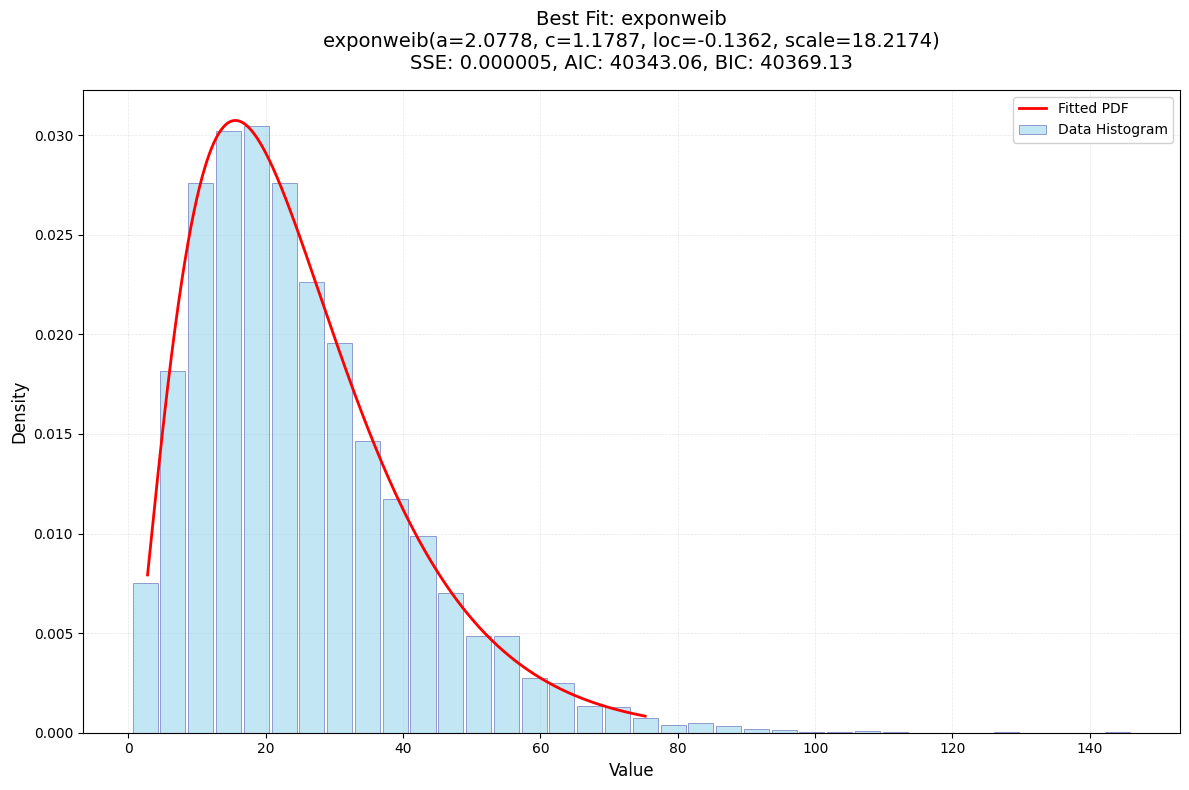

In [32]:
# Plot the best fit
best = top_3[0]
fitter.plot(best, df, "value", title=f"Best Fit: {best.distribution}")
plt.show()

## 3. Distribution Fitting with Ray Dataset (Distributed)

For larger datasets, use Ray Dataset for distributed aggregation. This avoids collecting raw data to the driver.

In [33]:
import ray

# Create a larger dataset
large_data = np.random.normal(loc=100, scale=25, size=50000)
large_df = pd.DataFrame({"value": large_data})

# Convert to Ray Dataset
ds = ray.data.from_pandas(large_df)
print(f"Ray Dataset created with {ds.count()} rows")

Ray Dataset created with 50000 rows


In [34]:
# Fit using Ray Dataset - distributed histogram and sampling
fitter = DistributionFitter(backend=backend)
results = fitter.fit(ds, column="value", max_distributions=15)

best = results.best(n=1)[0]
print(f"Best fit: {best.distribution}")
print(f"  Parameters: {dict(zip(best.get_param_names(), best.parameters))}")
print(f"  KS statistic: {best.ks_statistic:.6f}")
print(f"  AIC: {best.aic:.2f}")

2026-01-04 16:36:20,031	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2026-01-04 16:36:20,032	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2026-01-04_16-36-14_781943_15733/logs/ray-data
2026-01-04 16:36:20,033	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-01-04 16:36:20,043	INFO progress_bar.py:213 -- === Ray Data Progress {Project} ===
2026-01-04 16:36:20,044	INFO progress_bar.py:215 -- Project: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 16:36:20,046	INFO progress_bar.py:213 -- === Ray Data Progress {HashAggregate(key_columns=(), num_partitions=1)} ===
2026-01-04 16:36:20,046	INFO progress_bar.py:215 -- Hash

Best fit: beta
  Parameters: {'a': 153220782.02629435, 'b': 3098.7229263041654, 'loc': -67990964.62821478, 'scale': 67992439.70471296}
  KS statistic: 0.005589
  AIC: 93032.57


In [35]:
# Verify the fit captures the data statistics
# Data was generated with np.random.normal(loc=100, scale=25)
samples = best.sample(size=10000)
print(f"Data statistics: mean={large_data.mean():.2f}, std={large_data.std():.2f}")
print(f"Fitted samples:  mean={samples.mean():.2f}, std={samples.std():.2f}")

Data statistics: mean=99.98, std=25.01
Fitted samples:  mean=99.98, std=24.75


## 4. Multi-Column Fitting with Ray Dataset

In [36]:
# Create multi-column dataset
multi_data = pd.DataFrame({
    "revenue": np.random.lognormal(mean=10, sigma=1, size=10000),
    "quantity": np.random.poisson(lam=50, size=10000).astype(float),
    "rating": np.random.beta(a=8, b=2, size=10000) * 5,  # 0-5 scale
})

# Convert to Ray Dataset
multi_ds = ray.data.from_pandas(multi_data)

# Fit all columns
results = fitter.fit(multi_ds, columns=["revenue", "quantity", "rating"], max_distributions=10)

# Best per column
for col, fits in results.best_per_column(n=1).items():
    print(f"{col}: {fits[0].distribution} (AIC={fits[0].aic:.2f})")

2026-01-04 16:36:22,062	INFO logging.py:397 -- Registered dataset logger for dataset dataset_14_0
2026-01-04 16:36:22,064	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_14_0. Full logs are in /tmp/ray/session_2026-01-04_16-36-14_781943_15733/logs/ray-data
2026-01-04 16:36:22,064	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_14_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-01-04 16:36:22,070	INFO progress_bar.py:213 -- === Ray Data Progress {Project} ===
2026-01-04 16:36:22,071	INFO progress_bar.py:215 -- Project: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 16:36:22,071	INFO progress_bar.py:213 -- === Ray Data Progress {HashAggregate(key_columns=(), num_partitions=1)} ===
2026-01-04 16:36:22,071	INFO progress_bar.py:215 -- H

revenue: betaprime (AIC=227952.99)
quantity: beta (AIC=67289.29)
rating: beta (AIC=16258.06)


## 5. Discrete Distribution Fitting

In [37]:
from spark_bestfit import DiscreteDistributionFitter

# Generate count data
count_data = np.random.poisson(lam=12, size=3000)
count_df = pd.DataFrame({"events": count_data})

# Convert to Ray Dataset
count_ds = ray.data.from_pandas(count_df)

# Fit discrete distributions
discrete_fitter = DiscreteDistributionFitter(backend=backend)
discrete_results = discrete_fitter.fit(count_ds, column="events", max_distributions=5)

# Best by AIC (recommended for discrete)
best_discrete = discrete_results.best(n=1, metric="aic")[0]
print(f"Best discrete: {best_discrete.distribution}")
print(f"  Parameters: {dict(zip(best_discrete.get_param_names(), best_discrete.parameters))}")
print(f"  AIC: {best_discrete.aic:.2f}")
print(f"  Data mean: {count_data.mean():.2f}")

2026-01-04 16:36:27,804	INFO logging.py:397 -- Registered dataset logger for dataset dataset_44_0
2026-01-04 16:36:27,805	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_44_0. Full logs are in /tmp/ray/session_2026-01-04_16-36-14_781943_15733/logs/ray-data
2026-01-04 16:36:27,806	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_44_0: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(random_sample)->Project]
2026-01-04 16:36:27,810	INFO progress_bar.py:213 -- === Ray Data Progress {MapBatches(random_sample)->Project} ===
2026-01-04 16:36:27,811	INFO progress_bar.py:215 -- MapBatches(random_sample)->Project: Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 16:36:27,811	INFO progress_bar.py:213 -- === Ray Data Progress {Running Dataset} ===
2026-01-04 16:36:27,811	INFO progress_bar.py:215 -- Running Dataset: dataset_44_0. Active & requested resources: 0/10 CPU, 0.0

Best discrete: betabinom
  Parameters: {'n': 33.0, 'a': 18.831167163471303, 'b': 33.41400117636003}
  AIC: 15991.31
  Data mean: 11.89


## 6. Gaussian Copula with RayBackend

The Gaussian Copula uses RayBackend for distributed correlation computation and sample generation.

In [38]:
from spark_bestfit import GaussianCopula

# Create correlated data
n = 5000
x = np.random.normal(0, 1, n)
correlated_data = pd.DataFrame({
    "feature_a": x * 10 + 50,  # Normal-like
    "feature_b": np.exp(0.5 * x + np.random.normal(0, 0.3, n)),  # Log-normal-like
    "feature_c": np.abs(x) * 20 + np.random.exponential(5, n),  # Right-skewed
})

# Fit marginal distributions
marginal_results = fitter.fit(
    correlated_data, 
    columns=["feature_a", "feature_b", "feature_c"],
    max_distributions=10
)

print("Marginal fits:")
for col, fits in marginal_results.best_per_column(n=1).items():
    print(f"  {col}: {fits[0].distribution}")

Marginal fits:
  feature_a: burr12
  feature_b: betaprime
  feature_c: burr12


In [39]:
# Fit copula (correlation computed via RayBackend)
copula = GaussianCopula.fit(marginal_results, correlated_data, backend=backend)

print("\nCorrelation matrix:")
print(copula.correlation_matrix.round(3))


Correlation matrix:
[[ 1.     0.844  0.002]
 [ 0.844  1.    -0.001]
 [ 0.002 -0.001  1.   ]]


In [40]:
# Generate correlated samples
samples = copula.sample(n=1000)

# Verify correlation is preserved
sample_df = pd.DataFrame(samples)
print("Sample correlation matrix:")
print(sample_df.corr().round(3))

Sample correlation matrix:
           feature_a  feature_b  feature_c
feature_a      1.000      0.778     -0.000
feature_b      0.778      1.000      0.011
feature_c     -0.000      0.011      1.000


## 7. Distributed Sample Generation

RayBackend's `generate_samples` distributes sample generation across workers.

In [41]:
# Generate large sample using RayBackend
best_fit = results.for_column("revenue").best(n=1)[0]

# Local sampling (small scale)
local_samples = best_fit.sample(size=10000)
print(f"Local samples: mean={local_samples.mean():.2f}, std={local_samples.std():.2f}")

# For very large samples, use the backend's generate_samples
def sample_generator(n_samples, partition_id, seed):
    np.random.seed(seed)
    return {"value": best_fit.sample(size=n_samples)}

large_samples = backend.generate_samples(
    n=100000,
    generator_func=sample_generator,
    column_names=["value"],
    num_partitions=4,
    random_seed=42
)

print(f"\nDistributed samples: {len(large_samples)} rows")
print(f"  mean={large_samples['value'].mean():.2f}, std={large_samples['value'].std():.2f}")

Local samples: mean=36201.57, std=65520.77

Distributed samples: 100000 rows
  mean=35992.68, std=61397.14


## 8. Performance Comparison: pandas vs Ray Dataset

For small datasets, pandas is faster (no serialization overhead). For large datasets, Ray Dataset provides distributed aggregation.

In [42]:
import time

# Small dataset comparison
small_data = pd.DataFrame({"value": np.random.exponential(5, 1000)})
small_ds = ray.data.from_pandas(small_data)

# pandas DataFrame
start = time.time()
_ = fitter.fit(small_data, column="value", max_distributions=5)
pandas_time = time.time() - start

# Ray Dataset
start = time.time()
_ = fitter.fit(small_ds, column="value", max_distributions=5)
ray_time = time.time() - start

print(f"Small dataset (1K rows):")
print(f"  pandas: {pandas_time:.2f}s")
print(f"  Ray Dataset: {ray_time:.2f}s")
print(f"  Recommendation: Use pandas for small datasets")

2026-01-04 16:36:28,279	INFO logging.py:397 -- Registered dataset logger for dataset dataset_48_0
2026-01-04 16:36:28,281	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_48_0. Full logs are in /tmp/ray/session_2026-01-04_16-36-14_781943_15733/logs/ray-data
2026-01-04 16:36:28,282	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_48_0: InputDataBuffer[Input] -> TaskPoolMapOperator[Project] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-01-04 16:36:28,289	INFO progress_bar.py:213 -- === Ray Data Progress {Project} ===
2026-01-04 16:36:28,289	INFO progress_bar.py:215 -- Project: Tasks: 1 [backpressured:tasks]; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-04 16:36:28,290	INFO progress_bar.py:213 -- === Ray Data Progress {HashAggregate(key_columns=(), num_partitions=1)} ===
2026-01-04 16:36:28,290	INFO progress_bar.py:215 -- H

Small dataset (1K rows):
  pandas: 0.03s
  Ray Dataset: 1.74s
  Recommendation: Use pandas for small datasets


## Summary

**RayBackend provides:**

- Same API as SparkBackend and LocalBackend
- Works with both pandas DataFrame and Ray Dataset
- Distributed aggregation for large datasets (histograms, correlations)
- Parallel distribution fitting using Ray tasks
- Integration with Ray ML pipelines

**When to use RayBackend:**

| Scenario | Recommended Backend |
|----------|--------------------|
| Local development/testing | LocalBackend |
| Spark cluster available | SparkBackend |
| Ray cluster or Ray-based ML pipeline | RayBackend |
| Data already in Ray Dataset | RayBackend |

In [43]:
# Shutdown Ray (optional - useful in notebooks)
ray.shutdown()